# Example of a 90° twisted nematic liquid crystal

Author: O. Castany, M. Müller

Consider the following situation:
- twisted liquid crystal with 90° twist between z=0 and z=d
- liquid crystal aligned along x at z=0.
- input and output polarizers aligned parallel to x

Gooch-Tarry law gives: T_pp = sin²(pi/2·√(1+u²)) / (1+u²),
with u = 2dΔn/λ.
The transmission minima are given by u = ((2m)²-1)^{-1/2} = √(3),√(15),√(35),…

We consider a birefringence Δn = 0.10 and a thickness d = 4.33 µm. The first
minimum should be at λ = 500 nm, or k0 = 1.257e7 m⁻¹.

Note: Gooch-Tarry law does not take into account interferences between the two
glass substrates. A glass with n = 1.55 minimizes the interferences.

In [1]:
import elli
import elli.plot as elliplot
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.scimath import sqrt
from scipy.constants import c, pi

## Set parameters

In [2]:
# Materials
glass = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(1.55))
front = back = glass

# Liquid crystal oriented along the x direction
(no, ne) = (1.5, 1.6)
Dn = ne - no
LC = elli.UniaxialMaterial(
    elli.ConstantRefractiveIndex(no), elli.ConstantRefractiveIndex(ne)
)
R = elli.rotation_v_theta(elli.E_Y, 90)
LC.set_rotation(R)
d = 4330
TN = elli.TwistedLayer(LC, d, 7, 90)

# Structure
s = elli.Structure(front, [TN], back)

# Calculation parameters
(lbda_min, lbda_max) = (200e-9, 1)  #  (m)
k0_list = np.linspace(2 * pi / lbda_max, 2 * pi / lbda_min)
lbda_list = (2 * pi) / k0_list * 1e9

## Calculate theoretical curve with Gooch-Tarry law

In [3]:
u = 2 * d * Dn / lbda_list
GT = np.sin(pi / 2 * sqrt(1 + u**2)) ** 2 / (1 + u**2)

## Simulate with pyElli

In [4]:
TN.set_divisions(7)
data = s.evaluate(lbda_list, 0)
T7 = np.real(data.T_pp)

TN.set_divisions(18)
data2 = s.evaluate(lbda_list, 0)
T18 = np.real(data2.T_pp)

## Plot

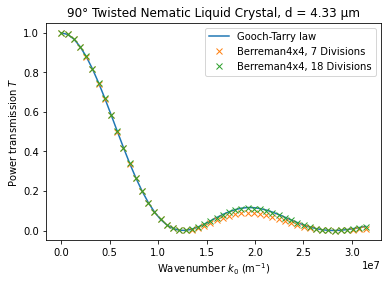

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot Gooch-Tarry law, for comparison
ax.plot(k0_list, GT, label="Gooch-Tarry law")

# Two plots are made, with 7 or 18 divisions in the TwistedMaterial
ax.plot(k0_list, T7, "x", label="Berreman4x4, 7 Divisions")
ax.plot(k0_list, T18, "x", label="Berreman4x4, 18 Divisions")

ax.set_title("90° Twisted Nematic Liquid Crystal, " + "d = {:.2f} µm".format(d * 1e-3))
ax.set_xlabel(r"Wavenumber $k_0$ (m$^{-1}$)")
ax.set_ylabel(r"Power transmission $T$")
ax.legend()
plt.show()

## Plot Structure

<AxesSubplot:xlabel='z (nm)', ylabel="n'">

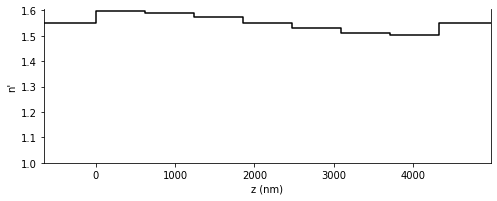

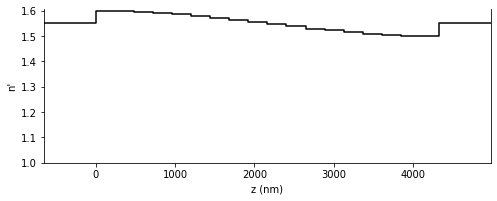

In [6]:
TN.set_divisions(7)
elliplot.draw_structure(s)
TN.set_divisions(18)
elliplot.draw_structure(s)